## Clustering method

This tutorial gives a bit more detail about clustering methods and how to implement your own.


In [1]:
# Prerequisites
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

# Include this once we have a published release to fetch test data
# from toad.utils import download_test_data
# download_test_data()

In [2]:
from toad import TOAD
from toad.shifts import ASDETECT

td = TOAD("test_data/garbe_2020_antarctica.nc", time_dim="GMST")
td.data = td.data.coarsen(x=3, y=3, GMST=3, boundary="trim").reduce(np.mean)

/Users/jakobharteg/miniconda3/envs/toad312/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [3]:
td.compute_shifts("thk", method=ASDETECT(), overwrite=True)

INFO: New shifts variable thk_dts: min/mean/max=-1.000/-0.223/0.897 using 1642 grid cells. Skipped 58.6% grid cells: 0 NaN, 2327 constant.


The `td.compute_clusters` function accepts clustering methods from the `sklearn.cluster` module.


In [4]:
from sklearn.cluster import DBSCAN, HDBSCAN

# HDBSCAN
td.compute_clusters(
    "thk",
    method=HDBSCAN(
        min_cluster_size=5,
    ),
    shift_threshold=0.5,
)

# DBSCAN
td.compute_clusters(
    "thk",
    method=DBSCAN(
        eps=0.1,
        min_samples=5,
        metric="euclidean",  # optional, defaults to 'euclidean'
    ),
    shift_threshold=0.5,
)

INFO: New cluster variable thk_dts_cluster: Identified 25 clusters in 1,633 pts; Left 23.1% as noise (378 pts).
INFO: New cluster variable thk_dts_cluster_1: Identified 28 clusters in 1,633 pts; Left 87.0% as noise (1,420 pts).



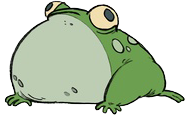

In [5]:
td

## Defining your own clustering method

You can also define your own clustering method by extending the `sklearn.base.ClusterMixin` and `sklearn.base.BaseEstimator` classes:


In [6]:
from sklearn.base import ClusterMixin, BaseEstimator


# Your custom clustering class must inherit from ClusterMixin and BaseEstimator
class MyClusterer(ClusterMixin, BaseEstimator):
    # Pass params to your method here
    def __init__(self, my_param):
        self.my_param = my_param

    # required method to perform clustering
    def fit_predict(self, coords: np.ndarray, weights=None, **kwargs):
        cluster_labels_array = ...  # your clustering algorithm here
        return cluster_labels_array


# Then apply it with TOAD
# td.compute_clusters('thk',
#     method=MyClusterer(
#         my_param=(1, 2.0, 2.0), # time, x, y thresholds
#     ),
#     shift_threshold=0.8,
#     overwrite=True,
# )

Real example of a custom clustering method:


In [6]:
from sklearn.base import BaseEstimator, ClusterMixin


class ExampleClusterer(ClusterMixin, BaseEstimator):
    # required method
    def __init__(self, my_param=(0.5, 1.0, 1.0)):
        self.my_param = my_param

    # required method
    def fit_predict(self, coords: np.ndarray, weights=None, **kwargs):
        # Perform extremely crude clustering
        clusters = []
        cluster_labels_array = []
        for point in coords:
            for i, centroid in enumerate(clusters):
                if all(abs(point - centroid) <= self.my_param):
                    break
            else:
                clusters.append(point)
                i = len(clusters) - 1
            cluster_labels_array.append(i)

        return cluster_labels_array


td.compute_clusters(
    "thk",
    method=ExampleClusterer(
        my_param=(0.5, 2.0, 2.0),  # time, x, y thresholds
    ),
    shift_threshold=0.9,
    # overwrite=True,
)

INFO: New cluster variable thk_dts_cluster_2: Identified 17 clusters in 1,103 pts; Left 0.0% as noise (0 pts).



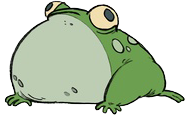

In [7]:
td

We can inspect all method params in the attributes


In [8]:
# get attributes of last cluster variable
td.get_clusters(td.cluster_vars[-1]).attrs

{'standard_name': 'land_ice_thickness',
 'long_name': 'land ice thickness',
 'units': 'm',
 'pism_intent': 'model_state',
 'time_dim': 'GMST',
 'method_name': 'ExampleClusterer',
 'toad_version': '0.3',
 'base_variable': 'thk',
 'variable_type': 'cluster',
 'method_ignore_nan_warnings': 'False',
 'method_lmin': '5',
 'method_segmentation': 'two_sided',
 'cluster_ids': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 'shift_threshold': 0.9,
 'shift_selection': 'local',
 'shift_direction': 'both',
 'scaler': 'StandardScaler',
 'time_scale_factor': 1,
 'n_data_points': 1103,
 'runtime_preprocessing': 0.020125150680541992,
 'runtime_clustering': 0.015676021575927734,
 'runtime_total': 0.03580117225646973,
 'shifts_variable': 'thk_dts',
 'method_my_param': '(0.5, 2.0, 2.0)'}

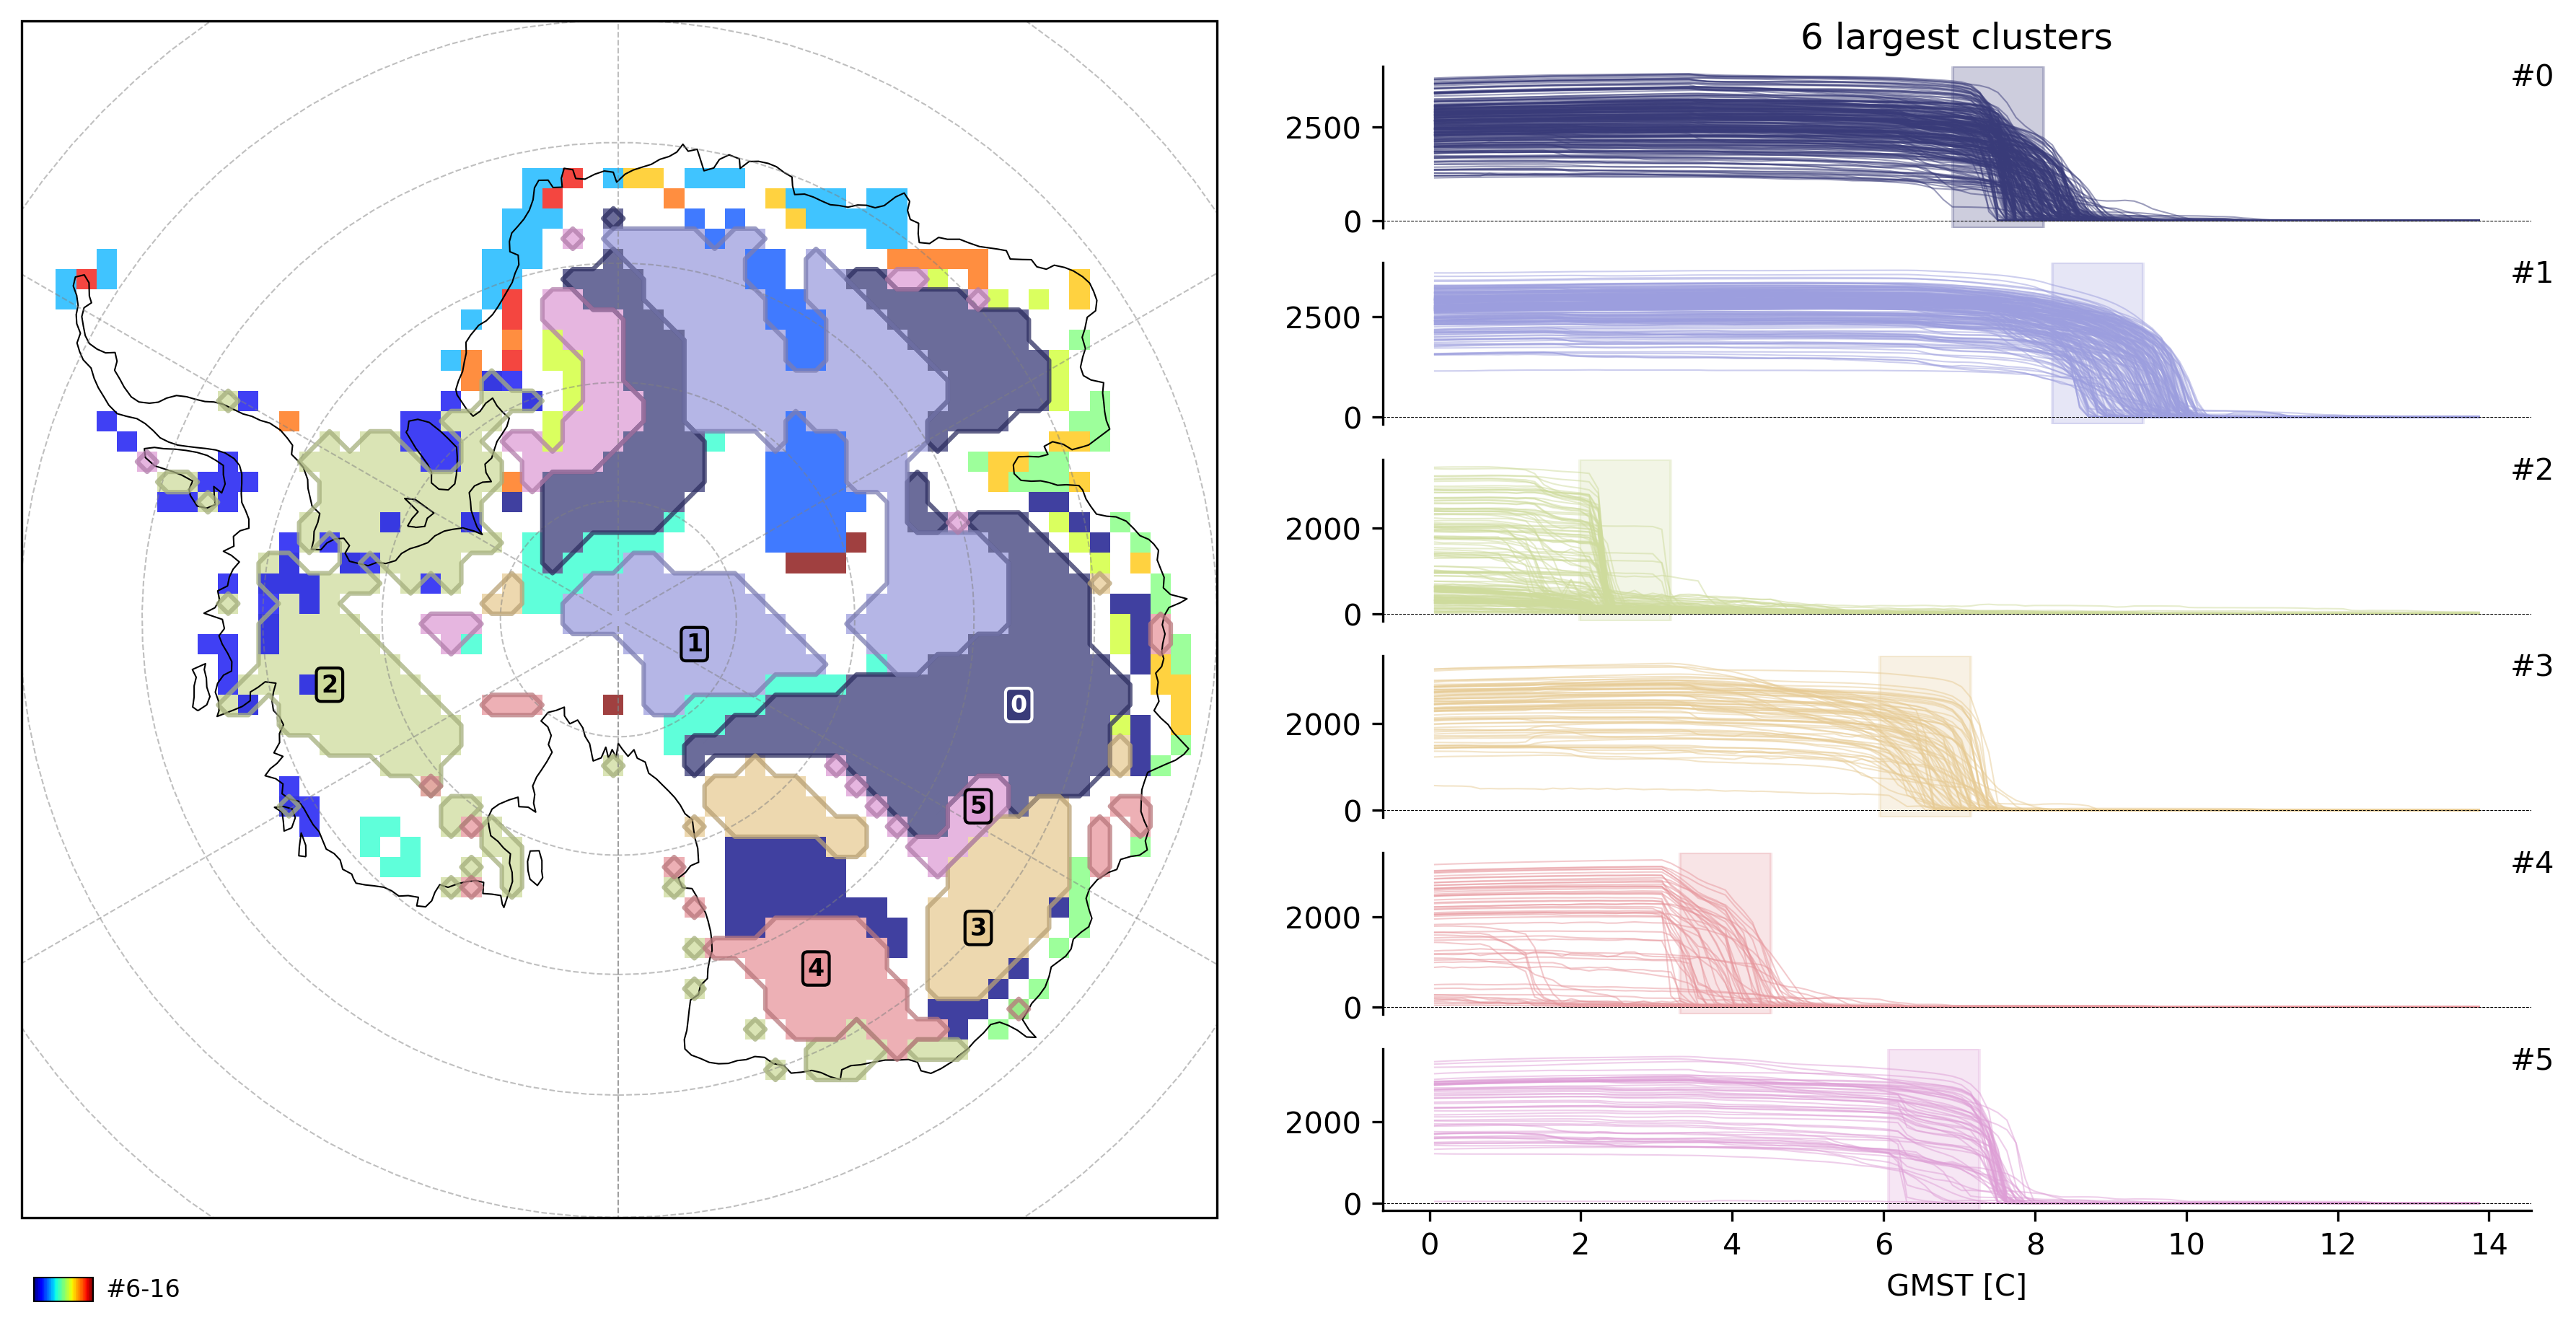

In [10]:
td.plot.overview(td.cluster_vars[-1], map_style={"projection": "south_pole"});